# 3 Automatic feature selection for LDA as regression

## 3.1 Implement Orthogonal Matching Pursuit (8 points)

In [1]:
import copy
import numpy as np
from scipy.linalg import lstsq

<div style="color: green; font-weight: bold">

Essentially the same solution. However we don't return A. We also preallocate A and B and return early if there is no residual left. We compute the residual and print it at every step. We also use scipy to solve the least squares problem. We compute the inactive betas explicitly.

</div>

In [2]:
def omp_regression(X, y, T):
    """Orthogonal Matching Pursuit is a simple greedy sparse regression algorithm. It approximates
    the exact algorithms for least squares under L1 regularization

    :param X: Input Matrix of shape R^NxD
    :param y: Output Vector of shape R^N
    :param T: The desired number of non zero elements in the final solution 
    :return beta_ts, optimal_t: The solution weights at each time t and the t where the solution is closest to the real solution.
    """

    assert T > 0, "Number of non zero Elements is smaller than 0"

    N = X.shape[0]
    D = X.shape[1]
    assert N == y.shape[0], "Dimension of Inputs and output does not match."

    # axtive matrix X 
    X_active = np.zeros(X.shape)
    # inactive matrix 
    X_inactive = copy.deepcopy(X)
    # zero matrix for generating inactive matrix
    zero_matrix = np.zeros(X.shape)
    # beta solution list
    beta_ts = np.zeros((D, T))

    A = np.array(D*[False])
    B = np.array(D*[True])
    r = y
    residual_norms = []

    for t in range(T): 
        # 1
        # Find most active column or 
        # maximal correlation with the current residual
        correlation = np.abs(np.dot(X.T, r))
        j = np.argmax(correlation)

        # 2
        # set active index to 1
        A[j] = True
        # remove active index from B and set to 0
        B[j] = False

        # 3
        # Select active A 
        X_active[:,A] = X[:,A]
        X_inactive[:,A] = zero_matrix[:,A]

        # 4
        # Calculate least squares
        beta_t, residue, rank, singular_value = lstsq(X_active, y)

        # 5
        # Update the residual
        r = y - np.dot(X_active, beta_t)
        residual_norms.append(np.linalg.norm(r)) 
        
        # Stop early if solution is found
        if np.sum(r) == 0: 
            break
        
        beta_ts[:, t] = beta_t
        print(f"Distance to optimal solution on train after {t+1} steps: {residual_norms[-1]}")
        print("#"*40)

    return beta_ts

In [3]:
X = np.random.randint(5, size=(3,10))
y = np.random.randint(5, size=(3))
T = 3

In [4]:
solutions = omp_regression(X, y, T)

Distance to optimal solution on train after 1 steps: 1.1602387022306428
########################################
Distance to optimal solution on train after 2 steps: 0.5015568278463086
########################################
Distance to optimal solution on train after 3 steps: 1.2947314098277875e-15
########################################


## 3.2 Classifcation with sparse LDA (8 points)

In [5]:
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

<div style="color: green; font-weight: bold">

We redistribute the data rather than balance it from the get go. Thus our dataset is complete compared to the sample solution.

</div>

In [6]:
def balance_training_split(X_train, X_test, y_train, y_test):
    """
    From a given train test split of binary data, balance training split.
    The split has to contain both labels for this algorithm to work.
    
    :param X_train: M x D, the training feature instances
    :param X_test: M x D, the test feature instances
    :param y_train: M x 1, the training labels
    :param y_test: M x 1, the test features
    """
    labels = np.unique(y_train)
    assert len(labels) == 2, "The split has to contain both labels for this algorithm to work."
    
    train_class_0_idx = np.where(y_train == labels[0])[0]
    train_class_1_idx = np.where(y_train == labels[1])[0]
    test_class_0_idx = np.where(y_test == labels[0])[0]
    test_class_1_idx = np.where(y_test == labels[1])[0]
    diff = np.abs(len(train_class_0_idx) - len(train_class_1_idx))
    
    to_test_idx = []
    to_train_idx = []
    if diff % 2 != 0:
        if len(train_class_0_idx) > len(train_class_1_idx):
            to_test_idx.append(train_class_0_idx[0])
            train_class_0_idx = np.delete(train_class_0_idx, 0)
        else:
            to_test_idx.append(train_class_1_idx[0])
            train_class_1_idx = np.delete(train_class_1_idx, 0)
        diff -= 1
    
    if diff > 0:
        switched_elements = list(range(int(diff/2)))
        if len(train_class_0_idx) > len(train_class_1_idx):
            to_test_idx += train_class_0_idx[switched_elements].tolist()
            train_class_0_idx = np.delete(train_class_0_idx, switched_elements)
            to_train_idx = test_class_1_idx[switched_elements].tolist()
            test_class_1_idx = np.delete(test_class_1_idx, switched_elements)
        else:
            to_test_idx += train_class_1_idx[switched_elements].tolist()
            train_class_1_idx = np.delete(train_class_1_idx, switched_elements)
            to_train_idx = test_class_0_idx[switched_elements].tolist()
            test_class_0_idx = np.delete(test_class_0_idx, switched_elements)
    
    
    y_to_test = y_train[to_test_idx]
    X_to_test = X_train[to_test_idx]
    y_to_train = y_test[to_train_idx]
    X_to_train = X_test[to_train_idx]
    
    y_train = np.delete(y_train, to_test_idx)
    X_train = np.delete(X_train, to_test_idx, axis=0)
    y_test = np.delete(y_test, to_train_idx)
    X_test = np.delete(X_test, to_train_idx, axis=0)
    
    y_train = np.concatenate([y_train, y_to_train])
    X_train = np.concatenate([X_train, X_to_train], axis=0)
    y_test = np.concatenate([y_test, y_to_test])
    X_test = np.concatenate([X_test, X_to_test], axis=0)
    
    return X_train, X_test, y_train, y_test
        
    

In [7]:
# load and select data
digits = load_digits()

data = digits["data"]
images = digits["images"]
target = digits["target"]
target_names = digits["target_names"]

# filter data to images with label 3 or 9
idx = (target == 3) | (target == 9)
data_cleaned = data[idx]
images_cleaned = images[idx]
target_cleaned = target[idx]

# relabel labels 3 and 9 to -1, 1
idx_target_3 = (target_cleaned == 3)
idx_target_9 = (target_cleaned == 9)
target_cleaned[idx_target_3] = -1
target_cleaned[idx_target_9] = 1

# split the data 
X_train, X_test, y_train, y_test = train_test_split(data_cleaned, target_cleaned)

# balance training data
X_train, X_test, y_train, y_test = balance_training_split(X_train, X_test, y_train, y_test)

<div style="color: green; font-weight: bold">
The data standardization is basically the same with the exception that we fill NaN values with 0.
</div>

In [8]:
def standardize_data(data: np.ndarray):
    """
    Do data standardization: x_standardized = (x - mean(x)) / std(x)
    
    :param data: N x D ndarray containing the data to be standarized.
    """
    centralized_data = data - np.mean(data, axis=0)  
    std_dev = np.std(data, axis=0)
    standardized_data = centralized_data / std_dev
    # For dimensions with std_dev = 0 choose standardized_data = 0
    # For these entries the Z-score is defined as 0
    zero_std_dev = std_dev == 0
    standardized_data[:, zero_std_dev] = 0
    return standardized_data

In [9]:
data_cleaned_standardized = standardize_data(data_cleaned)

scaler = StandardScaler()
data_cleaned_sklearn_standardized = scaler.fit_transform(data_cleaned)

# verify if our solution is correct
print(f"Our standard scaling standard deviation and mean:\n{np.std(data_cleaned_standardized)}, {np.mean(data_cleaned_standardized)}")
print(f"Sklearn's standard scaling standard deviation and mean:\n{np.std(data_cleaned_sklearn_standardized)}, {np.mean(data_cleaned_sklearn_standardized)}")

Our standard scaling standard deviation and mean:
0.9354143466934854, -1.5292328162880945e-19
Sklearn's standard scaling standard deviation and mean:
0.9354143466934854, -1.5292328162880945e-19


/tmp/ipykernel_17617/2403962991.py:9: RuntimeWarning: invalid value encountered in true_divide
  standardized_data = centralized_data / std_dev


In [10]:
# Scale the test and training data
X_standardized_train = standardize_data(X_train)
X_standardized_test = standardize_data(X_test)

/tmp/ipykernel_17617/2403962991.py:9: RuntimeWarning: invalid value encountered in true_divide
  standardized_data = centralized_data / std_dev


In [11]:
# for non-standardized images
solutions_digits = omp_regression(X_train, y_train, X_train.shape[1])

Distance to optimal solution on train after 1 steps: 13.915025701524401
########################################
Distance to optimal solution on train after 2 steps: 8.870110705921896
########################################
Distance to optimal solution on train after 3 steps: 8.540165900419137
########################################
Distance to optimal solution on train after 4 steps: 7.78826891685411
########################################
Distance to optimal solution on train after 5 steps: 7.278822350683555
########################################
Distance to optimal solution on train after 6 steps: 7.002903782491763
########################################
Distance to optimal solution on train after 7 steps: 6.4968017600884105
########################################
Distance to optimal solution on train after 8 steps: 6.263334102419298
########################################
Distance to optimal solution on train after 9 steps: 6.12400397794607
#################################

In [12]:
# for standardized images
solutions_standardized_digits = omp_regression(X_standardized_train, y_train, X_standardized_train.shape[1])

Distance to optimal solution on train after 1 steps: 10.881641649376581
########################################
Distance to optimal solution on train after 2 steps: 8.854083917667381
########################################
Distance to optimal solution on train after 3 steps: 7.856843624497157
########################################
Distance to optimal solution on train after 4 steps: 7.338428098819996
########################################
Distance to optimal solution on train after 5 steps: 6.828241236680242
########################################
Distance to optimal solution on train after 6 steps: 6.32592592713819
########################################
Distance to optimal solution on train after 7 steps: 6.16284441377525
########################################
Distance to optimal solution on train after 8 steps: 5.9979524347077104
########################################
Distance to optimal solution on train after 9 steps: 5.897293046572178
#################################

In [13]:
def predict(solutions, X_train, X_test):
    # we can assume that the mean over all is the same as the mean over each class 
    # since there are balanced in train
    mu = np.mean(X_train, axis=0)
    lhs = np.dot(X_test, solutions)
    rhs = np.dot(mu, solutions)
    return np.sign(lhs - rhs)

def error_rates(predictions, y_test):
    errors = np.abs((predictions.T - y_test)/2)
    return np.mean(errors, axis=1)

In [14]:
errors = error_rates(predict(solutions_digits, X_train, X_test), y_test)
error_rates_standardized = error_rates(predict(solutions_standardized_digits, X_standardized_train, X_standardized_test), y_test)

<div style="color: green; font-weight: bold">
Our prediction method is wrong therefore our error rates look very different to sample solution. Activation order missing. We can fix the prediction by just multiplying or betas with X and taking the sign.
</div>

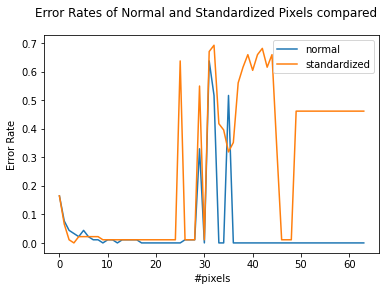

In [15]:
plt.plot(list(range(len(errors))), errors, label="normal")
plt.plot(list(range(len(error_rates_standardized))), error_rates_standardized, label="standardized")
plt.legend()
plt.suptitle("Error Rates of Normal and Standardized Pixels compared")
plt.xlabel("#pixels")
plt.ylabel("Error Rate")
plt.show()

Between 10 and 20 pixels we have a high probability to get a perfect classifier. With 3 to 5 pixels we see an error rate of at or below 5 percent.

Standardization did not give us signifcant improvements in classification quality though we suspect that it could be more stable in some scenarios.

Unfortunately, we were not able to finish the pixel visualization in time. We would propose an animated image which activates the pixels according if the respective dimensions in beta_t are nonzero. Then we would look at an averaged 3 image and decide whether the respective beta votes for or against 3 by looking if the average brightness is smaller or larger than some threshold (e.g. 0.2 of the max brightness).

Depending on how well we chose the pixels in exercise 1 we would see overlap with the solution here since OMP will choose the most optimal pixels for the classification task first.